# Iranian Tweet EDA and Topic Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

### Data Filtering

In [2]:
data = pd.read_csv('data/iranian_tweets.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122936 entries, 0 to 1122935
Data columns (total 31 columns):
tweetid                     1122936 non-null int64
userid                      1122936 non-null object
user_display_name           1122936 non-null object
user_screen_name            1122936 non-null object
user_reported_location      887669 non-null object
user_profile_description    995845 non-null object
user_profile_url            434954 non-null object
follower_count              1122936 non-null int64
following_count             1122936 non-null int64
account_creation_date       1122936 non-null object
account_language            1122936 non-null object
tweet_language              1117307 non-null object
tweet_text                  1122936 non-null object
tweet_time                  1122936 non-null object
tweet_client_name           1100078 non-null object
in_reply_to_tweetid         339350 non-null float64
in_reply_to_userid          440244 non-null object
quoted_twe

In [4]:
df = data[['userid','tweet_language','tweet_text','is_retweet','hashtags']]

In [5]:
df = df[(df.is_retweet==False)&(df.tweet_language=='en')]

### Tokenize & Lemmatize, Remove Punctuation

In [6]:
# Tfidf vectorizer takes care of stop words; it's on us to remove links, punctuation (can include in token pattern?)

In [7]:
punc = set(string.punctuation+'‘’…°–—“”')
lem = nltk.stem.WordNetLemmatizer()
twt = TweetTokenizer(reduce_len=True, strip_handles=True)

def tweet_tokenize_full(tweet):
    tokens = twt.tokenize(tweet)
    no_punc = [token for token in tokens if (token[0] not in punc) and (len(token)>2)]
    no_links = [token for token in no_punc if token[0:4]!='http']
    lemmatized = [lem.lemmatize(token) for token in no_links]
    return lemmatized

In [8]:
num_feats = 1000
ngrams = (1,3)
vctr = TfidfVectorizer(analyzer='word',
                       stop_words='english',
                       tokenizer=tweet_tokenize_full,
                       max_features=num_feats,
                       ngram_range=ngrams)

In [9]:
X = vctr.fit_transform(df.tweet_text)

In [10]:
tfidf_vals = X.toarray()

In [11]:
feature_names = np.array(vctr.get_feature_names())

In [12]:
tfidf_results = pd.DataFrame(data = tfidf_vals, columns=feature_names)

In [13]:
n_components = 4
nmf = NMF(n_components=n_components, random_state=1, alpha=0.1, solver='mu', max_iter=1000, l1_ratio=0.5).fit(X)

In [14]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print("Topic #{0}: {1}".format(topic_idx, top_words))
        print('\n')
    print()

In [15]:
n_top_words = 20
print_top_words(nmf, feature_names, n_top_words)

Topic #0: ['state', 'united', 'united state', 'racist', 'society', 'racist society', 'state structurally', 'structurally racist society', 'united state structurally', 'structurally racist', 'structurally', 'state structurally racist', 'nation', 'nation state', 'set nation state', 'set nation', 'inferno set', 'inferno set nation', "ferguson's inferno", "ferguson's inferno set"]


Topic #1: ['day', 'attack', 'usa', 'terrorist', 'terrorist attack', 'predict', 'usa day', 'predict terrorist', 'predict terrorist attack', 'cia predict', 'cia predict terrorist', 'cia', 'pakistan', 'pakistan usa day', 'pakistan usa', 'attack sidney', 'sidney', 'terrorist attack sidney', 'sidney pakistan', 'attack sidney pakistan']


Topic #2: ['iran', 'saudi', 'isi', 'trump', 'arabia', 'saudi arabia', '3081cc5899cfede8252c2015644ffeccd7b27b1149fb', 'israel', 'ha', 'donald', 'new', 'secret', 'donald trump', 'say', 'prince', 'syria', 'wa', 'american', 'toonsonline', 'war']


Topic #3: ['cfb 431d28838bc87b3473081c

In [16]:
nmf.components_.shape

(4, 1000)

In [17]:
tfidf_results.shape

(172929, 1000)

In [18]:
arr = []
for i in tfidf_results.values:
    arr.append(np.argmax(np.sum(i*nmf.components_,axis=1)))

In [19]:
df['topic'] = np.array(arr)

In [20]:
df.head()

,userid,tweet_language,tweet_text,is_retweet,hashtags,topic
1,299148448,en,@ParkerLampe An inquiry by congress confirms t...,False,NaN,2
2,299148448,en,@hadeelhmaidi @wordpressdotcom CIA predict thi...,False,NaN,1
5,299148448,en,"@irfhabib why boko haram come europe,legally a...",False,NaN,2
6,299148448,en,"@KhushbuCNN ISIS militants,plan to target West...",False,NaN,2
7,299148448,en,@placesbrands Turkish intelligence chief: ISIS...,False,NaN,2


In [21]:
df['tweet_length'] = df.tweet_text.apply(lambda x: len(x))

In [22]:
df.tweet_length.head()

1    102
2    132
5     79
6     81
7    122
Name: tweet_length, dtype: int64

In [32]:
def tweet_tokenize(tweet):
    tokens = twt.tokenize(tweet)
    no_punc = [token for token in tokens if (token[0] not in punc)]
    no_links = [token for token in no_punc if token[0:4]!='http']
    return no_links

In [33]:
df['tokens'] = df.tweet_text.apply(tweet_tokenize)

In [34]:
df.tokens.head()

1    [An, inquiry, by, congress, confirms, that, IS...
2    [CIA, predict, third, terrorist, attack, after...
5    [why, boko, haram, come, europe, legally, and,...
6    [ISIS, militants, plan, to, target, Western, c...
7    [Turkish, intelligence, chief, ISIS, is, a, re...
Name: tokens, dtype: object

In [40]:
df['word_count'] = df.tokens.apply(lambda x: len(x))

In [41]:
df.word_count.head()

1    12
2    14
5     8
6     7
7    14
Name: word_count, dtype: int64

In [37]:
df.tweet_text.values[0:3]

array(['@ParkerLampe An inquiry by congress confirms that ISIS is indeed a CIA creation http://t.co/eFRmFwYZTV',
       '@hadeelhmaidi @wordpressdotcom CIA predict third terrorist attack after Sidney and Pakiistan in USA in 3 days http://t.co/IrPx7M223N',
       '@irfhabib why boko haram come europe,legally and easily? http://t.co/on2vzPqEPH'],
      dtype=object)

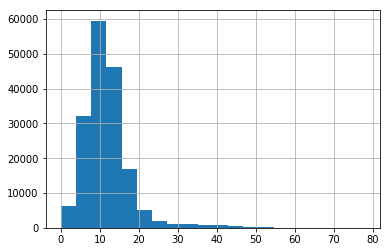

In [42]:
df.word_count.hist(bins=20)

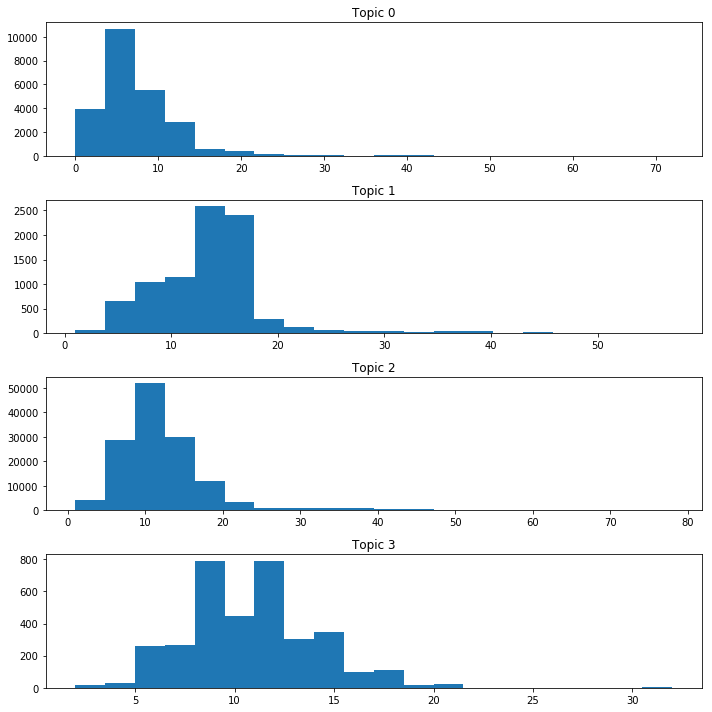

In [55]:
fig, ax = plt.subplots(4,1,figsize=(10,10))
for n in range(4):
    ax[n].hist(df[df.topic==n]['word_count'],bins=20)
    ax[n].set_title('Topic {}'.format(n))
plt.tight_layout()

In [57]:
df['word_lengths']=df.tokens.apply(lambda x: [len(i) for i in x])

In [58]:
df.word_lengths.head()

1            [2, 7, 2, 8, 8, 4, 4, 2, 6, 1, 3, 8]
2      [3, 7, 5, 9, 6, 5, 6, 3, 9, 2, 3, 2, 1, 4]
5                        [3, 4, 5, 4, 6, 7, 3, 6]
6                           [4, 9, 4, 2, 6, 7, 8]
7    [7, 12, 5, 4, 2, 1, 7, 3, 2, 3, 10, 5, 3, 6]
Name: word_lengths, dtype: object

In [61]:
df.head()

,userid,tweet_language,tweet_text,is_retweet,hashtags,topic,tweet_length,tokens,word_length,word_count,word_lengths
1,299148448,en,@ParkerLampe An inquiry by congress confirms t...,False,NaN,2,102,"[An, inquiry, by, congress, confirms, that, IS...",12,12,"[2, 7, 2, 8, 8, 4, 4, 2, 6, 1, 3, 8]"
2,299148448,en,@hadeelhmaidi @wordpressdotcom CIA predict thi...,False,NaN,1,132,"[CIA, predict, third, terrorist, attack, after...",14,14,"[3, 7, 5, 9, 6, 5, 6, 3, 9, 2, 3, 2, 1, 4]"
5,299148448,en,"@irfhabib why boko haram come europe,legally a...",False,NaN,2,79,"[why, boko, haram, come, europe, legally, and,...",8,8,"[3, 4, 5, 4, 6, 7, 3, 6]"
6,299148448,en,"@KhushbuCNN ISIS militants,plan to target West...",False,NaN,2,81,"[ISIS, militants, plan, to, target, Western, c...",7,7,"[4, 9, 4, 2, 6, 7, 8]"
7,299148448,en,@placesbrands Turkish intelligence chief: ISIS...,False,NaN,2,122,"[Turkish, intelligence, chief, ISIS, is, a, re...",14,14,"[7, 12, 5, 4, 2, 1, 7, 3, 2, 3, 10, 5, 3, 6]"


In [65]:
df[df.topic==2].tweet_text.values[0:100]

array(['@ParkerLampe An inquiry by congress confirms that ISIS is indeed a CIA creation http://t.co/eFRmFwYZTV',
       '@irfhabib why boko haram come europe,legally and easily? http://t.co/on2vzPqEPH',
       '@KhushbuCNN ISIS militants,plan to target Western capitals http://t.co/890VDVPE6o',
       '@placesbrands Turkish intelligence chief: ISIS is a reality and we are optimistic about the future! http://t.co/8HnO2uDac2',
       '@sedonaduck @MailOnline What would happen to you if you were a political dissent in Saudi Arabia? http://t.co/n1pHsz1UsX',
       '@curdistani @FiratGunay Saudi embassy in Turkey became a safe haven for ISIL terrorists http://t.co/BsMnfC1xqU',
       '@DOVEBRICK We can destroy Israel in ‘less than 12 minutes’: Pakistani commander https://t.co/CSkZ4Z6ke1',
       '@AllProDad what they will never tell you about Christmas http://t.co/ovd4gGlWLE',
       '@danabenj is there a secret collaboration between U.S and Iran against isis? http://t.co/Fw1IH3qOCb',
      

In [93]:
grouped_df = df.groupby('userid',as_index=False).agg(' '.join)[['tweet_text','userid']]

In [94]:
grouped_df.head()

,tweet_text,userid
0,"Happy #teachers_day. Miss my school days. BTW,...",00d0de71571f5fe235fe3fe967348c08a493a173a08a47...
1,hi twitter https://t.co/yRWv06RW27,02076c70fd70c8b29ce89bd11c802072cc51ef1850cbbe...
2,Tens of thousands of Syrians are being exiled ...,023f243ac3ec0852edb345a625ac7a4972e8fb4f225d86...
3,If these two pictures are not enough to make y...,02a0cf481804cdd531497c03e7bdf3941915b08cbe3e0b...
4,Why Isn't Fugitive Ex-Prosecutor In Prison? As...,02c7119c0fab4e8b2c16a2320cd6759f0220477471f1b0...


In [99]:
punc = set(string.punctuation+'‘’…°–—“”')
lem = nltk.stem.WordNetLemmatizer()
twt = TweetTokenizer(reduce_len=True, strip_handles=True)

def tweet_tokenize_full(tweet):
    tokens = twt.tokenize(tweet)
    no_punc = [token for token in tokens if (token[0] not in punc) and (len(token)>2) and (len(token)<13)]
    no_links = [token for token in no_punc if token[0:4]!='http']
    lemmatized = [lem.lemmatize(token) for token in no_links]
    return lemmatized

In [157]:
num_feats = 1000
ngrams = (1,3)
vctr = TfidfVectorizer(analyzer='word',
                       stop_words='english',
                       tokenizer=tweet_tokenize_full,
                       max_features=num_feats,
                       ngram_range=ngrams)

In [166]:
X = vctr.fit_transform(grouped_df.tweet_text)
n_components = 4
nmf = NMF(n_components=n_components, random_state=1, alpha=0.1, solver='mu', max_iter=1000, l1_ratio=0.5).fit(X)

In [167]:
n_top_words = 40
print_top_words(nmf, feature_names, n_top_words)

Topic #0: ['wa', 'paris', 'saudi prince warns', 'said', 'new age', 'ha infiltrated united', 'israeli mossad', 'israel jesus', 'photo', 'world', 'year', 'black', 'policy', 'daughter', 'war', 'killing', "iran's", 'woman', 'force child behead', 'video', 'threatens', 'syria', 'kill', 'reveals', 'representative turkey', 'attack', 'live', 'mark', 'treacherous policy', 'arab', 'najib', 'cost', 'support', 'state', 'sanction', 'like', 'kill son', 'father reaction', 'palestinian', 'ambassador']


Topic #1: ['turn city ash', 'kill', 'best', 'ha', 'alter jewishness', 'use', 'work', 'live', 'doe photo prouve', 'make', 'looming', 'video', 'siege success', 'force child', 'negotiate', 'praised', 'terrorist group', 'working', 'funny', 'family', 'donald trump 9/11', 'worked', 'hillary', 'watch', 'doomed', 'gaza einstein letter', 'girl school saudi', 'white', 'wish', 'collapse erdoğan continues', 'ban', 'believe', 'daesh', 'threatens', 'image', 'way', 'governed demagogue', 'want', 'haven', 'hoping oust']

In [168]:
X.shape

(345, 1000)

In [169]:
grouped_df.shape

(345, 3)

In [170]:
nmf.components_.shape

(4, 1000)

In [171]:
arr = []
for i in X.toarray():
    arr.append(np.argmax(np.sum(i*nmf.components_,axis=1)))

In [172]:
grouped_df['topic'] = arr

In [175]:
grouped_df.groupby('topic').count()['userid']

topic
0    257
1     32
2     28
3     28
Name: userid, dtype: int64

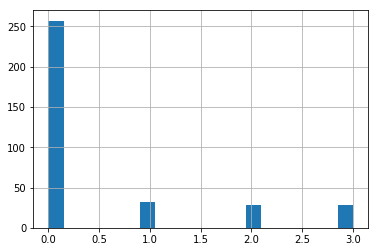

In [178]:
grouped_df.topic.hist(bins=20)